## Nesterov Accelerated Gradient

In this section, we look at how Nesterov's Accelerated Gradient (NAG) performs as our optimizer. This is partly inspired by [Sutskever et al. 2013](http://proceedings.mlr.press/v28/sutskever13.pdf) and [this stackoverflow](https://stackoverflow.com/questions/50774683/how-is-nesterovs-accelerated-gradient-descent-implemented-in-tensorflow) post on [TensorFlow's implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) of NAG.

### Theory vs Implementation

It is worth noting that the original NAG uses momentum to update weights. So for
- a weight $\theta_t$, <br>
- a loss function that we are minimizing $f(\cdot)$, 
- with gradient $\nabla f(\cdot)$, 
- momentum $\mu \in [0,1]$, 
- learning rate $\epsilon$, 
- and velocity $v_t$:

NAG is given by:
$$
\begin{eqnarray}
v_{t+1}^{(nag)} &=& \mu v_t + \epsilon \nabla f(\theta_t + \mu vt) \\
\theta_{t+1}^{(nag)} &=& \theta_t + v_{t+1}^{(nag)} 
\end{eqnarray}
$$

However, TensorFlow uses an approximation of this, which is described in the documentation as:
$$
\begin{eqnarray}
v_{t+1} &=& \mu v_t + \epsilon \nabla f(\theta_t) \\
\theta_{t+1}^{(tf)} &=& \theta_t + \mu v_{t+1}^{(tf)} - \epsilon \nabla f(\theta_t) 
\end{eqnarray}
$$


On the other hand, standard SGD in TensorFlow for $\mu > 0$ and $v_{t+1}$ described above is given by

$$
\begin{eqnarray}
\theta_{t+1} &=& \theta_t + v_{t+1}
\end{eqnarray}
$$

Which is described in the Sutskever paper as Classical Momentum (CM).

And for $\mu = 0$ SGD is given by
$$
\begin{eqnarray}
\theta_{t+1} &=& \theta_t - \epsilon \nabla f(\theta_t)
\end{eqnarray}, 
$$



This serves as an approximation to NAG which holds for $\mu \approx 1$ and gradient condition $\nabla f(\theta_t) <<< \mu v_t$. However, the latter approximation does not always hold, though we can rectify this to some extent by choosing a very small learning rate $\epsilon$. Depending on the nature of our dataset, this may mean that the learning rate has to be so small for our gradient condition to be met that a true NAG optimizer would end up being slower. As a result, we will optimise for learning rate to pick the best-performing option, though this may mean that we end up with $\epsilon$ too large for our optimiser to be a true NAG optimiser.

This may mean that our results are not ideal compared to a true NAG optimiser, but we should hopefully see faster convergence than traditional gradient descent. Namely, NAG should converge at rate $\frac{1}{k^2}$ compared to traditional gradient descent which converges at $\frac{1}{k}$ where k is the number of steps taken.

We note also that NAG should theoretically shine more when the learning procedure takes more steps to converge to some optima, i.e. where the data is such that deep learning is truly needed and is not quickly/easily optimised by shallow learning methods as in that case our neural network would converge in very small values of $k$ such that $k$ and $k^2$ would not be easily distinguishable.

### Import

In [ ]:
import time

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.utils import to_categorical

from mlxtend.plotting import plot_confusion_matrix


rseed = 42
np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

#### Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

#### Training

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

In [5]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [6]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Train binary and multiclass models for NAG, SGD, and Adam.

In [7]:
#jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

count = 1
epochs = 30
batch_size = 10**3
start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in epsilons:
    
    #create the 3 optimizer with learning rate above
#     sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
#                                       momentum = 0.9,
#                                       nesterov = False)

    nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                      momentum = 0.9, 
                                      nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['nag']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = 0)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = 0)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to nag optimizer with learning rate 0.1----------
----------Fitting categorical model to nag optimizer with learning rate 0.1----------

----------Fitting binary model to nag optimizer with learning rate 0.01----------
----------Fitting categorical model to nag optimizer with learning rate 0.01----------

----------Fitting binary model to nag optimizer with learning rate 0.001----------
----------Fitting categorical model to nag optimizer with learning rate 0.001----------

----------Fitting binary model to nag optimizer with learning rate 0.0001----------
----------Fitting categorical model to nag optimizer with learning rate 0.0001----------



In [8]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  340.606951 seconds


### Plots and Assessing Performance

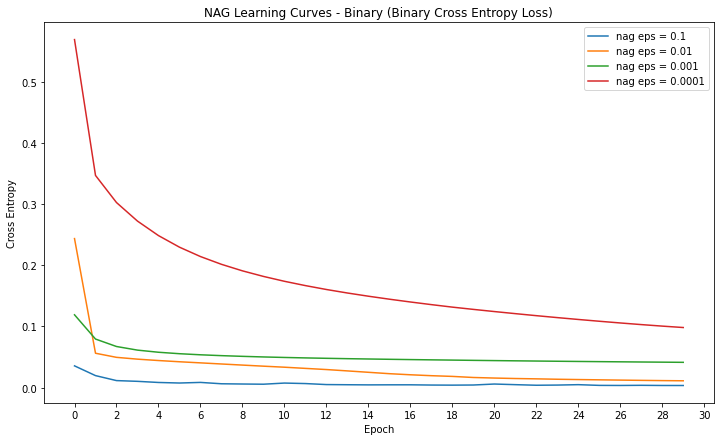

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('{} Learning Curves - Binary (Binary Cross Entropy Loss)'.format(opt.upper()))
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

count=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1


plt.legend()
plt.show()

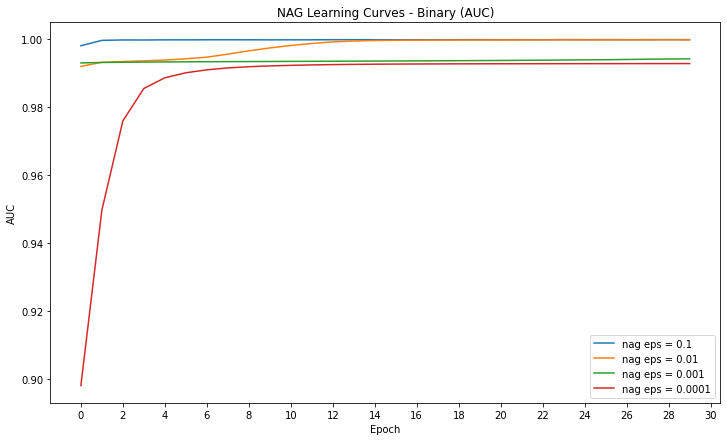

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')

count=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

plt.legend()
plt.show()

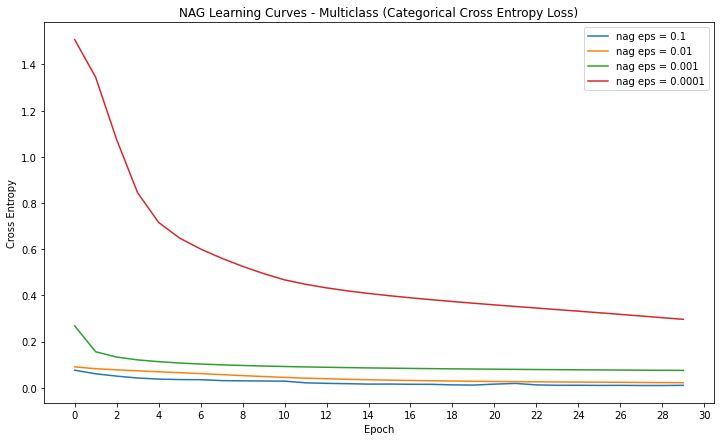

In [11]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

count=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1


plt.legend()
plt.show()

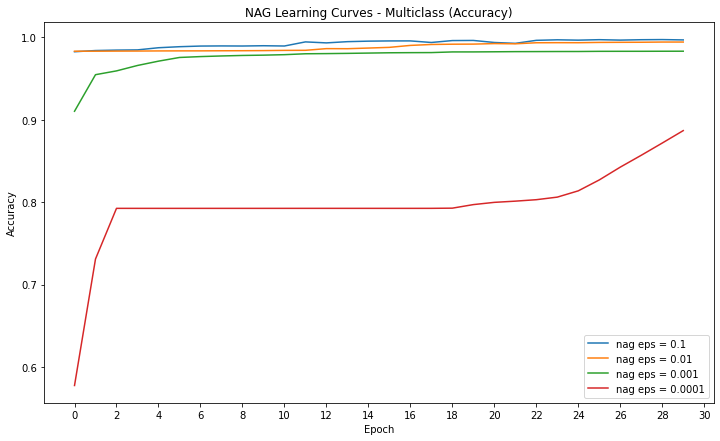

In [12]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

count=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1


plt.legend()
plt.show()

In [13]:
tf.random.set_seed(rseed)
nag_pred = nag_bin_model_1.predict(X_test)

In [14]:
nag_pred_bin = nag_pred
nag_pred_bin[nag_pred_bin>0.5]=1
nag_pred_bin[nag_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for NAG with learning rate 0.1')

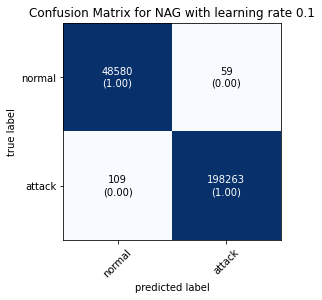

In [15]:
cmat_nag = confusion_matrix(y_test_bin,nag_pred)
cmat_nag

plot_confusion_matrix(
    conf_mat = cmat_nag,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for NAG with learning rate {}'.format(epsilons[0]))

In [16]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['nag_categ_model_{}'.format(i+1)]
    nag_categ_pred = model.predict(X_test)
    locals()['nag_categ_pred_{}'.format(i+1)] = nag_categ_pred

In [17]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

In [ ]:
for i in range(len(epsilons)):
    nag_categ_pred = locals()['nag_categ_pred_{}'.format(i+1)]
    
    cmat_categ_nag = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(nag_categ_pred,axis=1))
    
    locals()['cmat_categ_nag_{}'.format(i)] = cmat_categ_nag
   
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_nag,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))
    
del nag_categ_pred

# IGNORE EVERYTHING BELOW THIS FOR NOW

In [19]:
# def plotLC(optimizer = opt, epsilons = epsilons, metric = 'loss', model_type = 'bin'):
#     count = 1
#     epsilon = epsilons[count-1]
#     optimizer = opt.upper()
    
#     if model_type == 'bin':
#         if metric == 'loss':
#             model_title = 'Binary Crossentropy (Loss)'
#         else:
#             metric_title = 'Binary AUC'
#     else:
#         if metric == 'loss':
#             model_title = 'Categorical Crossentropy (Loss)'
#         else:
#             metric_title = 'Categorical Accuracy'
        
#     fig = plt.figure(figsize=(12,7))

#     plt.title('{opt} Learning Curves - {model_title} )'.format(opt.upper()))
#     plt.xlabel('Epoch')
#     plt.xticks(ticks=range(0,52,2))
#     plt.ylabel('Cross Entropy')

    